In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import datetime
import platform

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2025-07-21 10:36:27.660233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753094187.862759      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753094187.923656      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digits-dataset/Digits/6.jpg
/kaggle/input/digits-dataset/Digits/5.jpg
/kaggle/input/digits-dataset/Digits/8.jpg
/kaggle/input/digits-dataset/Digits/0.jpg
/kaggle/input/digits-dataset/Digits/9.jpg
/kaggle/input/digits-dataset/Digits/1.jpg
/kaggle/input/digits-dataset/Digits/7.jpg
/kaggle/input/digits-dataset/Digits/4.jpg
/kaggle/input/digits-dataset/Digits/3.jpg
/kaggle/input/digits-dataset/Digits/2.jpg


In [2]:
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.11.13
Tensorflow version: 2.18.0
Keras version: 3.8.0


In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.info(), train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


(None, (42000, 785))

In [6]:
test.info(),  test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


(None, (28000, 784))

In [7]:
X = train.iloc[:, 1:785]
y = train.iloc[:, 0]

X_test = test.iloc[:, 0:784]

In [ ]:
# WARNING: running t-SNE on the full data set takes a while.
X_tsn = X/255

from sklearn.manifold import TSNE
tsne = TSNE()

tsne_res = tsne.fit_transform(X_tsn)

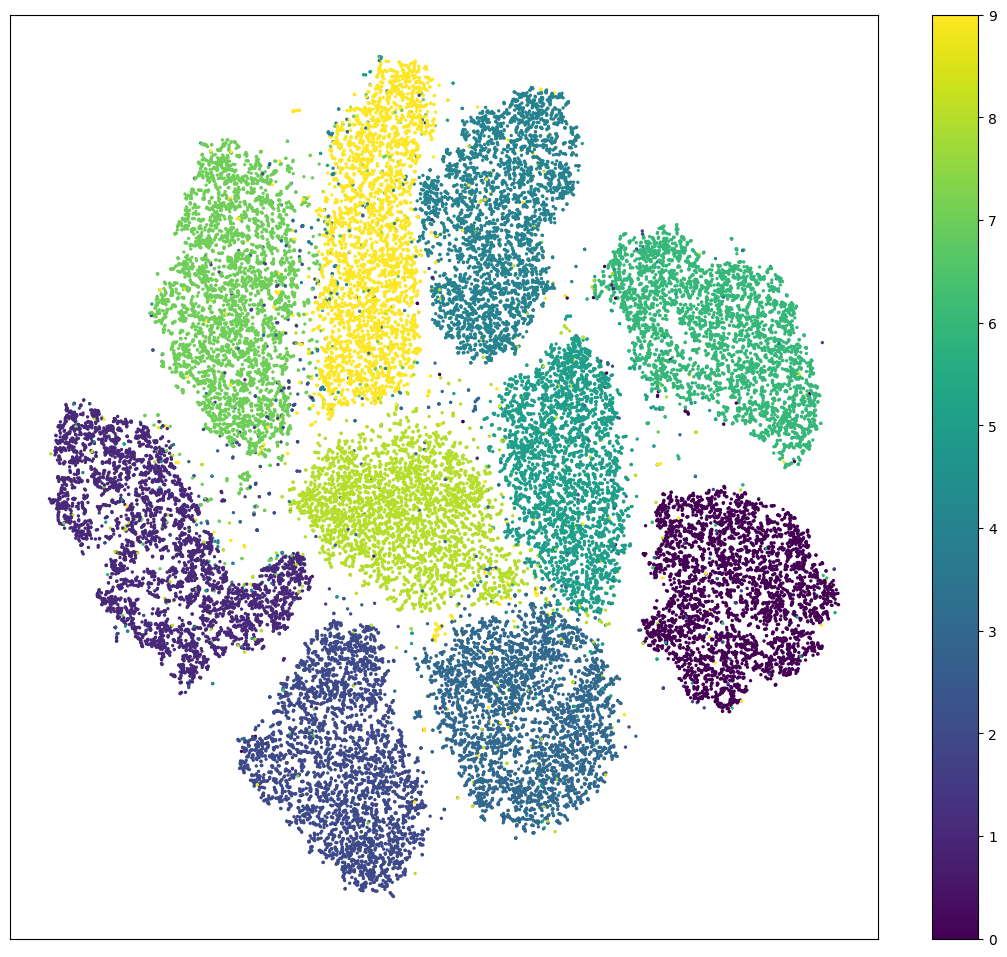

In [11]:
plt.figure(figsize=(14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar();

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2,random_state = 1212)

In [10]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_validation:', X_validation.shape)
print('y_validation:', y_validation.shape)

X_train: (33600, 784)
y_train: (33600,)
X_validation: (8400, 784)
y_validation: (8400,)


In [12]:
x_train_re = X_train.to_numpy().reshape(33600, 28, 28)
y_train_re = y_train.values
x_validation_re = X_validation.to_numpy().reshape(8400, 28, 28)
y_validation_re = y_validation.values
x_test_re = test.to_numpy().reshape(28000, 28, 28)

In [13]:
print('x_train:', x_train_re.shape)
print('y_train:', y_train_re.shape)
print('x_validation:', x_validation_re.shape)
print('y_validation:', y_validation_re.shape)
print('x_test:', x_test_re.shape)

x_train: (33600, 28, 28)
y_train: (33600,)
x_validation: (8400, 28, 28)
y_validation: (8400,)
x_test: (28000, 28, 28)


In [14]:
# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train_re.shape
IMAGE_CHANNELS = 1

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS);

IMAGE_WIDTH: 28
IMAGE_HEIGHT: 28
IMAGE_CHANNELS: 1


In [15]:
pd.DataFrame(x_train_re[0])

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,155,155,12,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,254,254,103,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,254,254,55,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,254,254,20,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,254,170,6,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,242,37,0,0,0,0,0,0,0,0


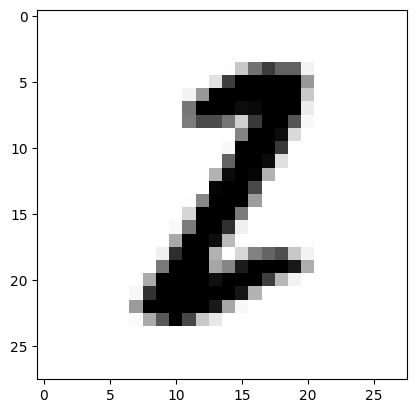

In [16]:
plt.imshow(x_train_re[0], cmap=plt.cm.binary)
plt.show()

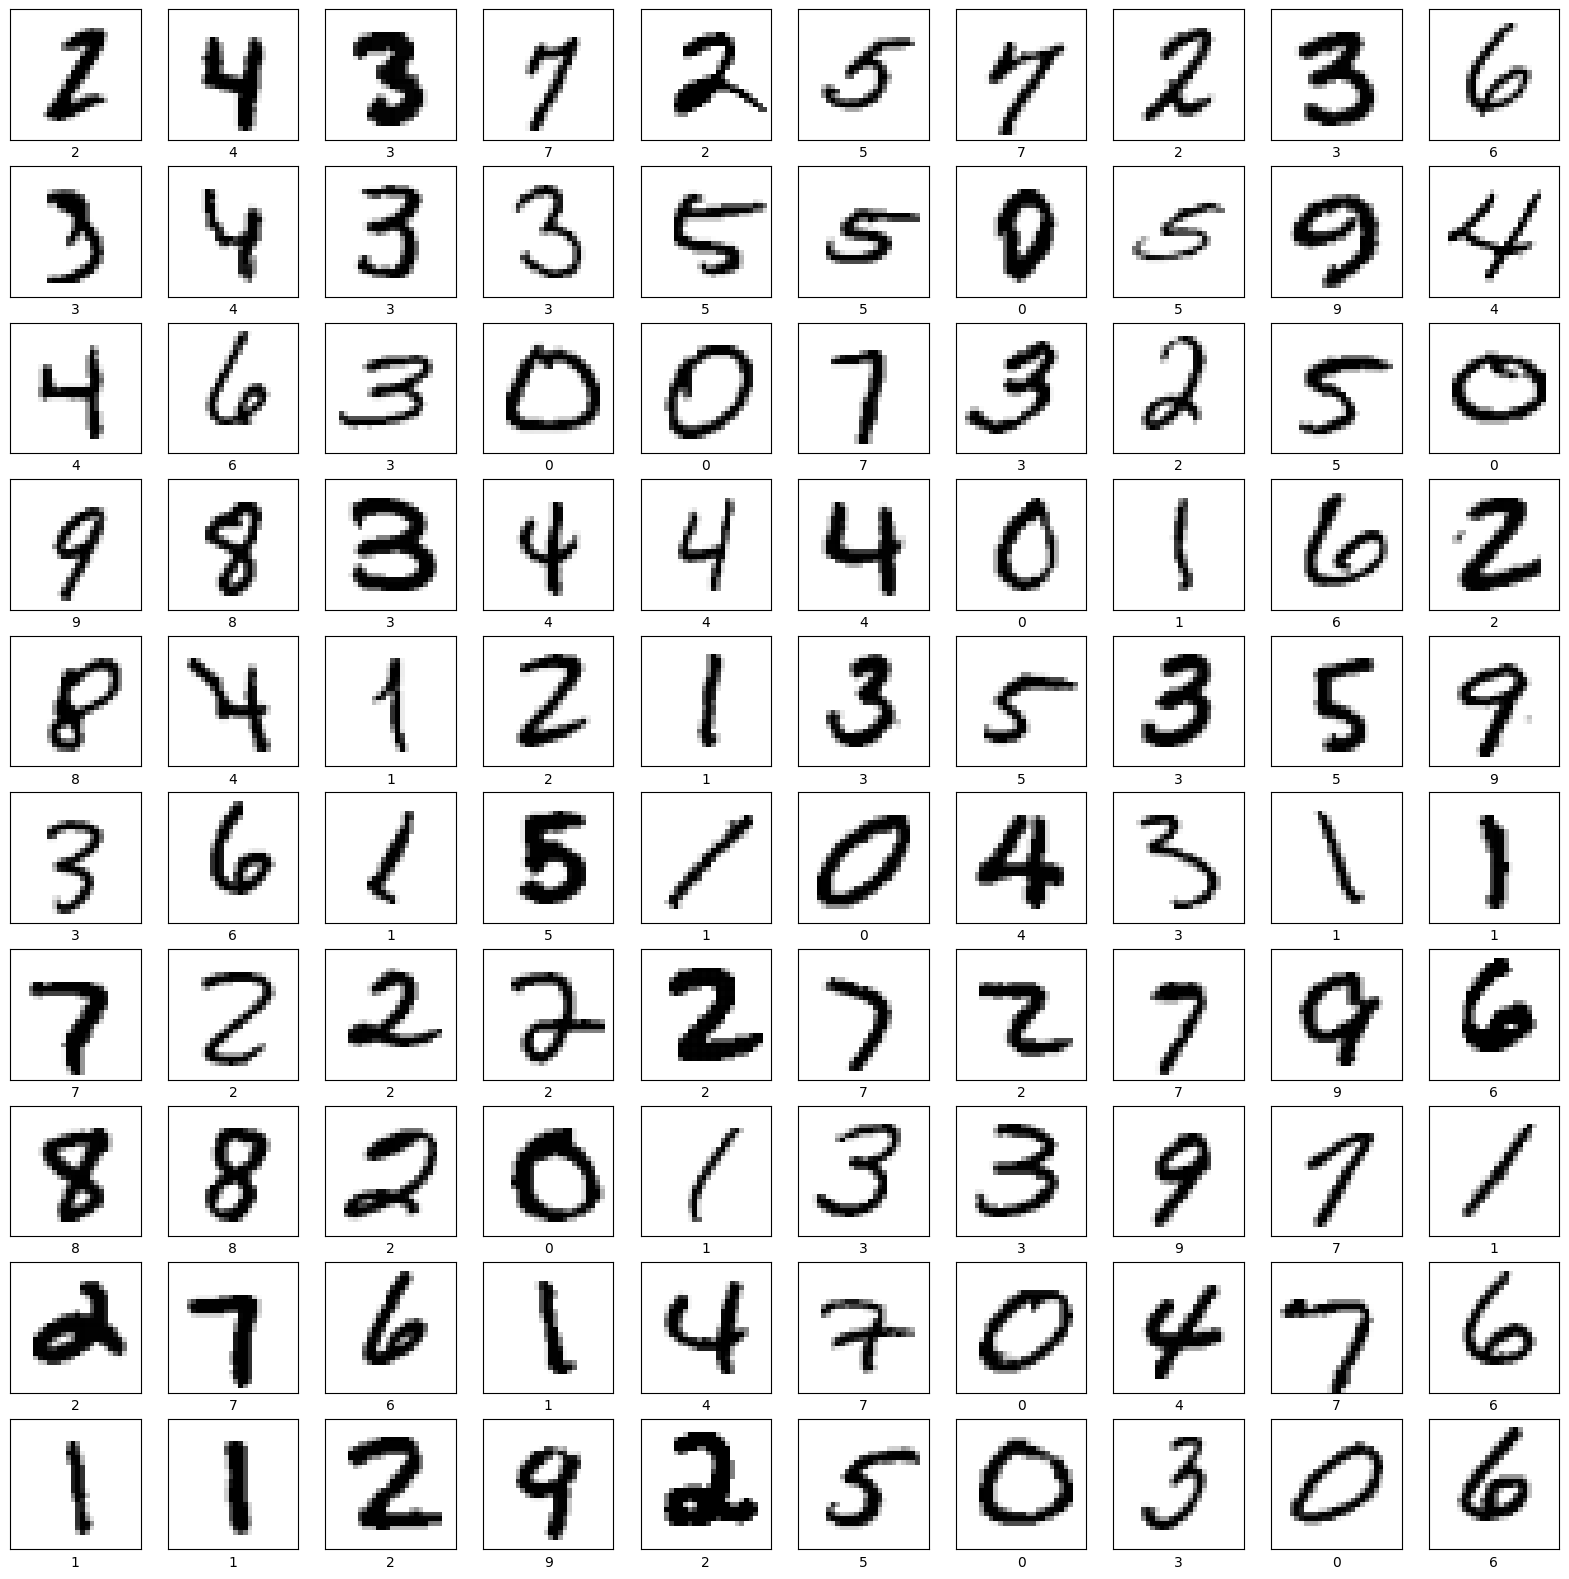

In [17]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(20,20))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_re[i], cmap=plt.cm.binary)
    plt.xlabel(y_train_re[i])
plt.show()

In [18]:
x_train_with_chanels = x_train_re.reshape(
    x_train_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_validation_with_chanels = x_validation_re.reshape(
    x_validation_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_test_with_chanels = x_test_re.reshape(
    x_test_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

In [19]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_validation_with_chanels:', x_validation_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (33600, 28, 28, 1)
x_validation_with_chanels: (8400, 28, 28, 1)
x_test_with_chanels: (28000, 28, 28, 1)


In [20]:
x_train_normalized = x_train_with_chanels / 255
x_validation_normalized = x_validation_with_chanels / 255
x_test_normalized = x_test_with_chanels / 255

In [21]:
# Let's check just one row from the 0th image to see color chanel values after normalization.
x_train_normalized[0][10]

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.02352941],
       [0.99607843],
       [0.99607843],
       [0.99607843],
       [0.76862745],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [22]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
));

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1753094739.076856      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753094739.077478      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,610 (146.91 KB)

 Trainable params: 37,610 (146.91 KB)

 Non-trainable params: 0 (0.00 B)

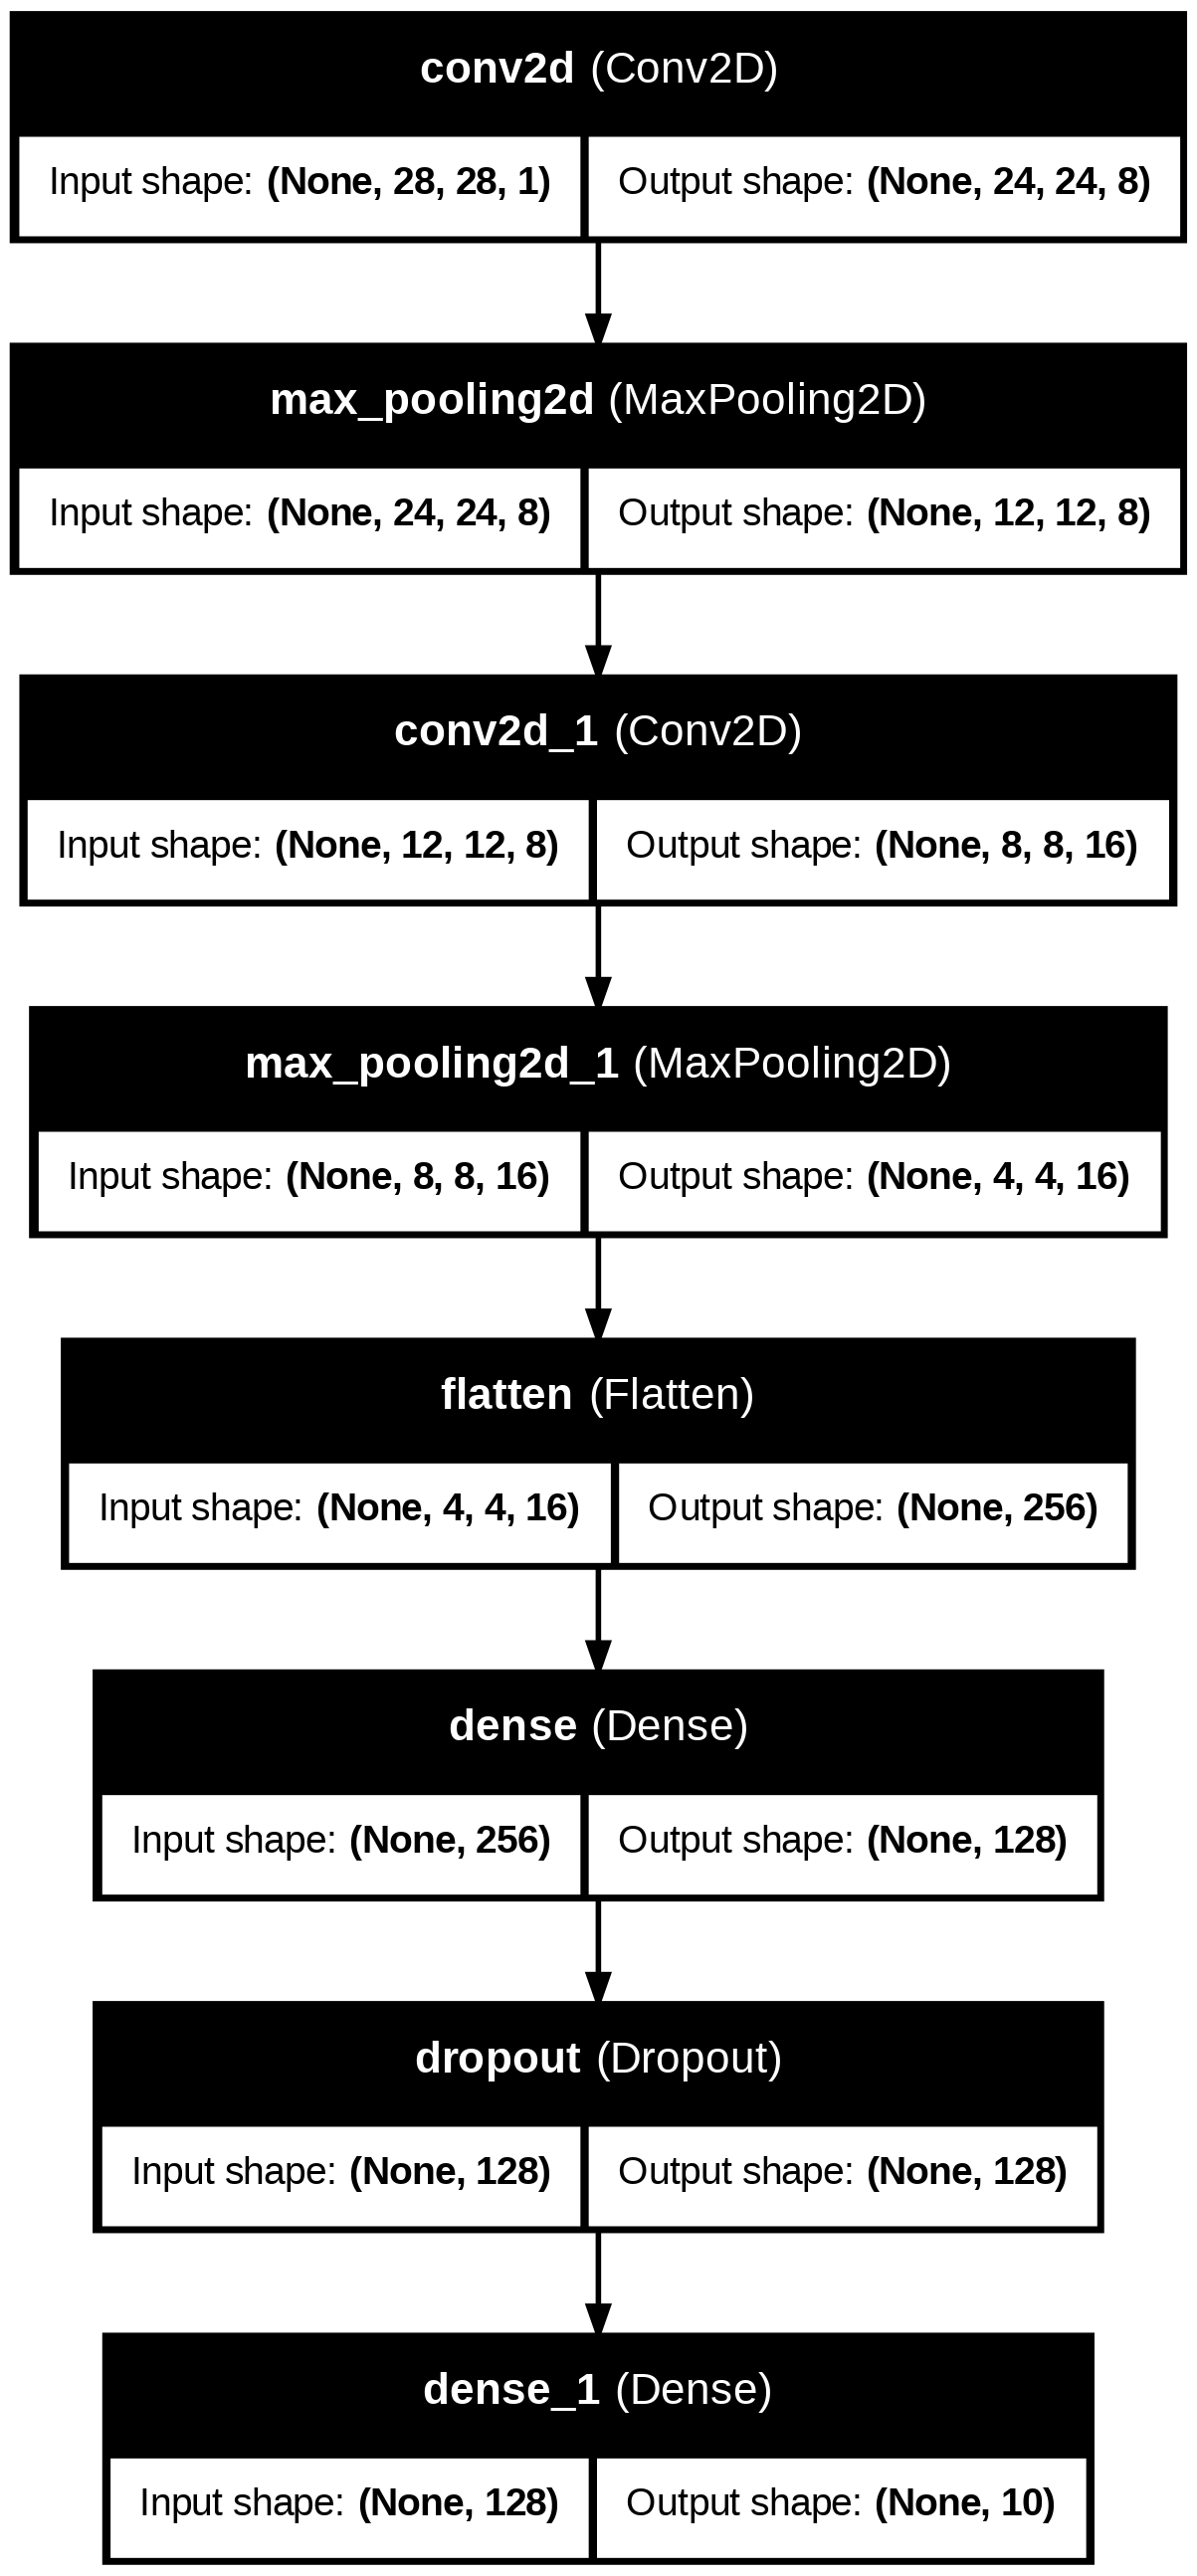

In [24]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [25]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [26]:
training_history = model.fit(
    x_train_normalized,
    y_train_re,
    epochs=10,
    validation_data=(x_validation_normalized, y_validation_re),
)

print("The model has successfully trained")

Epoch 1/10


I0000 00:00:1753094749.461804     112 service.cc:148] XLA service 0x7d751400e9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753094749.462766     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753094749.462786     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753094749.711274     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


  64/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3615 - loss: 1.8705

I0000 00:00:1753094752.105637     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8170 - loss: 0.5703 - val_accuracy: 0.9714 - val_loss: 0.0928
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9703 - loss: 0.0970 - val_accuracy: 0.9817 - val_loss: 0.0648
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9786 - loss: 0.0670 - val_accuracy: 0.9838 - val_loss: 0.0538
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9835 - loss: 0.0503 - val_accuracy: 0.9839 - val_loss: 0.0543
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9872 - loss: 0.0402 - val_accuracy: 0.9858 - val_loss: 0.0488
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9892 - loss: 0.0340 - val_accuracy: 0.9858 - val_loss: 0.0477
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9910 - loss: 0.0298 - val_accuracy: 0.9855 - val_loss: 0.0530
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9914 - loss: 0.0256 - val_accurac

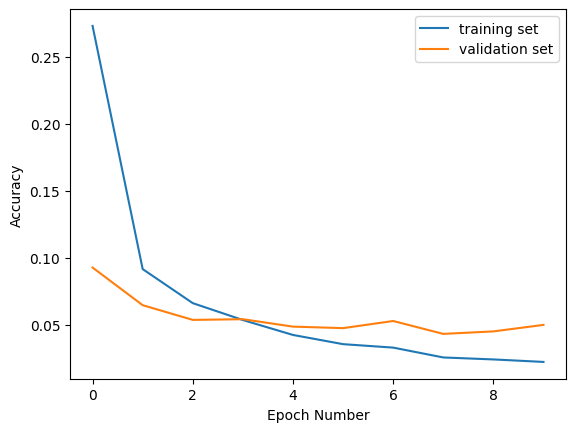

In [27]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='validation set')
plt.legend()

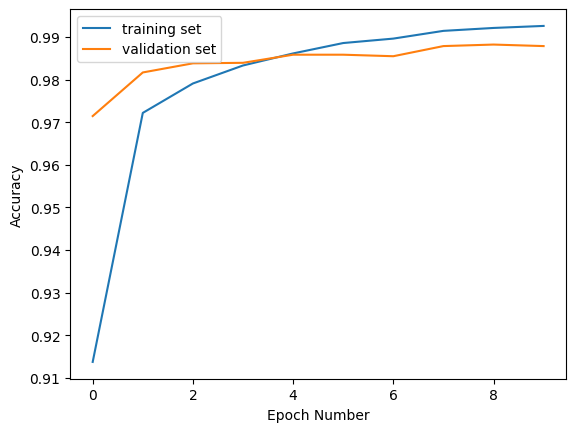

In [28]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='validation set')
plt.legend()

In [31]:
%%capture
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train_re)

In [32]:
print('Train loss: ', train_loss)
print('Train accuracy: ', train_accuracy)

Train loss:  0.009894110262393951
Train accuracy:  0.997083306312561


In [33]:
%%capture
validation_loss, validation_accuracy = model.evaluate(x_validation_normalized, y_validation_re)

In [34]:
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

Validation loss:  0.050058797001838684
Validation accuracy:  0.9878571629524231


In [35]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

In [36]:
loaded_model = tf.keras.models.load_model(model_name)

In [37]:
test_pred = pd.DataFrame( loaded_model.predict([x_test_normalized]))
test_pred = pd.DataFrame(test_pred.idxmax(axis = 1))
test_pred.index.name = 'ImageId'
test_pred = test_pred.rename(columns = {0: 'Label'}).reset_index()
test_pred['ImageId'] = test_pred['ImageId'] + 1

test_pred.head()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(32, 28, 28, 1))',)
  warnings.warn(msg)


875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
6.jpg --> Predicted Digit: 6


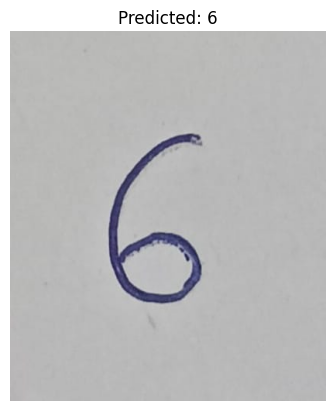

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
5.jpg --> Predicted Digit: 5


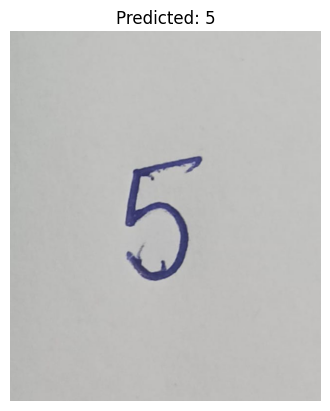

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8.jpg --> Predicted Digit: 8


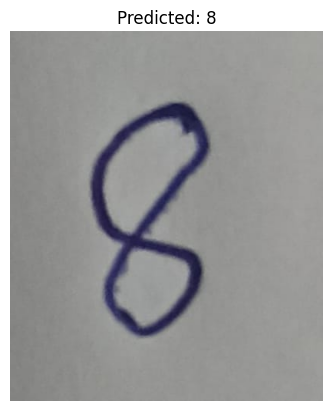

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.jpg --> Predicted Digit: 0


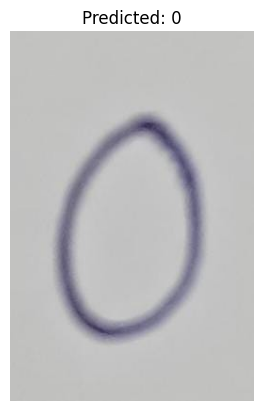

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
9.jpg --> Predicted Digit: 9


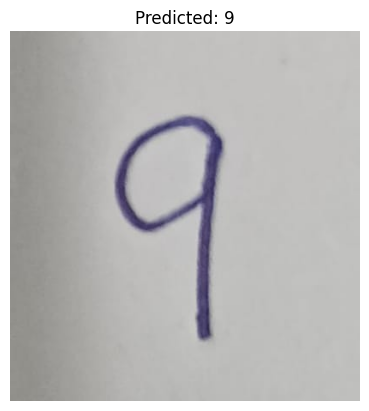

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1.jpg --> Predicted Digit: 1


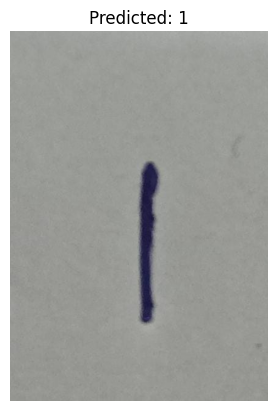

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7.jpg --> Predicted Digit: 7


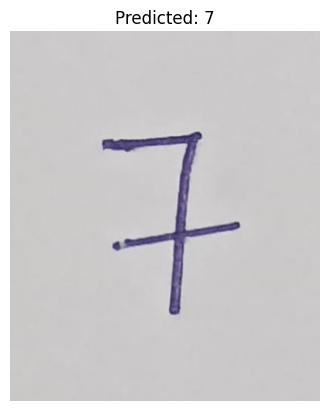

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4.jpg --> Predicted Digit: 4


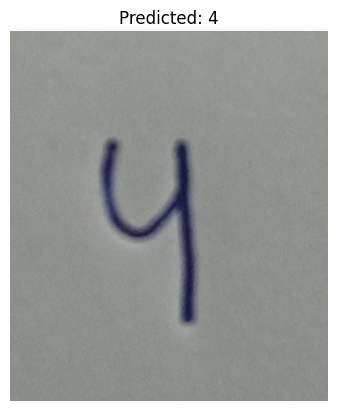

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3.jpg --> Predicted Digit: 3


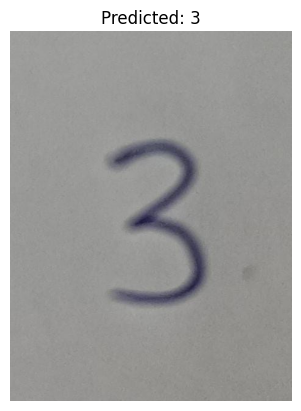

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2.jpg --> Predicted Digit: 2


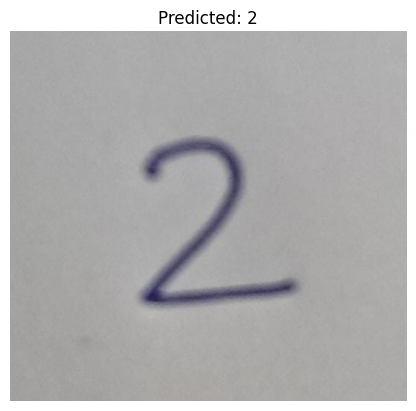

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# ------------------------------
# 1️⃣ Load your saved model
# ------------------------------
model = tf.keras.models.load_model('digits_recognition_cnn.h5')

# ------------------------------
# 2️⃣ Define helper: load & preprocess
# ------------------------------
def load_and_prepare_image(image_path):
    # Load image in grayscale
    img = Image.open(image_path).convert('L')  # 'L' mode for grayscale
    # Resize to 28x28
    img = img.resize((28, 28))
    # Convert to numpy
    img_array = np.array(img)
    # Invert colors if background is black and digits are white (optional)
    img_array = 255 - img_array
    # Normalize
    img_array = img_array / 255.0
    # Add channel dimension
    img_array = img_array.reshape(1, 28, 28, 1)
    return img_array

# ------------------------------
# 3️⃣ Load multiple images
# ------------------------------
# 👇 Put your images in a folder, e.g. 'custom_digits/'
custom_images_folder = '/kaggle/input/digits-dataset/Digits'

# Store predictions
for filename in os.listdir(custom_images_folder):
    if filename.endswith('.png') or filename.endswith('.jpg'):
        img_path = os.path.join(custom_images_folder, filename)
        img_prepared = load_and_prepare_image(img_path)
        
        # Predict
        prediction = model.predict(img_prepared)
        predicted_label = np.argmax(prediction)
        
        print(f"{filename} --> Predicted Digit: {predicted_label}")
        
        # Show the image
        img = Image.open(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
